## LOBSTER Anomaly Detection: LSTM Autoencoder (Reconstruction-Based)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
WINDOW_SIZE = 25
FEATURES = ["price", "ask_price1", "bid_price1", "spread", "imbalance", "SMA_ask_price", "SMA_bid_price"]
EPOCHS = 50
BATCH_SIZE = 128

In [3]:
import csv
import os
from datetime import datetime

def log_model_results(features=FEATURES, scaler=None, window_size=WINDOW_SIZE, train_loss=0, val_loss=0, 
                      notes=None, log_path="logs/model_log.csv", directory="logs"):

    row = {
        "model_id": f"model_{datetime.now().strftime("%Y%m%d_%H%M")}",
        "features": features,
        "scaler": scaler,
        "window_size": window_size,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "notes": notes,
    }

    if not os.path.exists(directory):
        os.makedirs(directory)

    file_exists = False
    try:
        with open(log_path, "r"):
            file_exists = True
    except FileNotFoundError:
        pass

    with open(log_path, mode="a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=row.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(row)
    
    print(f"Model logged to {log_path}.")

In [4]:
def save_model_with_id(model, directory='models'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    model_id = datetime.now().strftime("%Y%m%d_%H%M")

    model_path = os.path.join(directory, f"model_{model_id}.keras")
    model.save(model_path)
    print(f"Model saved to {model_path}")

In [5]:
import json

def save_training_history(history, directory='models'):
    model_id = datetime.now().strftime("%Y%m%d_%H%M")
    history_path = os.path.join(directory, f"model_{model_id}_history.json")
    with open(history_path, 'w') as f:
        json.dump(history.history, f)
    print(f"Training history saved to {history_path}")

## Loading and Merging Data

In [6]:
message_cols = ["time", "type", "orderID", "size", "price", "direction"]
orderbook_cols = ["ask_price1", "ask_size1", "bid_price1", "bid_size1"]

msgs = pd.read_csv("data/level1/AAPL_2012-06-21_34200000_57600000_message_1.csv", header=None, names=message_cols)
book = pd.read_csv("data/level1/AAPL_2012-06-21_34200000_57600000_orderbook_1.csv", header=None, names=orderbook_cols)

In [7]:
df = pd.concat([msgs.reset_index(drop=True), book.reset_index(drop=True)], axis=1)

## Feature Engineering

In [8]:
df["spread"] = df["ask_price1"] - df["bid_price1"]
df["mid_price"] = (df["ask_price1"] + df["bid_price1"]) / 2
df["imbalance"] = (df["ask_price1"] - df["bid_price1"])/(df["ask_price1"] + df["bid_price1"])
df["SMA_ask_price"] = df["ask_price1"].rolling(window=10).mean()
df["SMA_bid_price"] = df["bid_price1"].rolling(window=10).mean()
df = df[FEATURES].dropna().copy().reset_index(drop=True)

In [9]:
df

,price,ask_price1,bid_price1,spread,imbalance,SMA_ask_price,SMA_bid_price
0,5857300,5857500,5857300,200,0.000017,5858550.0,5855330.0
1,5857300,5857500,5857300,200,0.000017,5858360.0,5855730.0
2,5857500,5857500,5857300,200,0.000017,5858200.0,5856130.0
3,5857500,5857500,5857300,200,0.000017,5858030.0,5856530.0
4,5857500,5857500,5857300,200,0.000017,5857850.0,5856930.0
...,...,...,...,...,...,...,...
118483,5776000,5776700,5776000,700,0.000061,5776700.0,5775700.0
118484,5776000,5776700,5775400,1300,0.000113,5776700.0,5775690.0
118485,5776100,5776100,5775400,700,0.000061,5776640.0,5775680.0
118486,5776100,5776700,5775400,1300,0.000113,5776640.0,5775670.0


## Preprocessing

In [10]:
from sklearn.preprocessing import MinMaxScaler

def scale_sequences(sequences, scaler="standard_scaler"):
    scaled = []
    for seq in sequences:
        if scaler == "standard_scaler":
            scaler = StandardScaler()
        elif scaler == "min_max_scaler":
            scaler = MinMaxScaler((-1,1))
        scaled_seq = scaler.fit_transform(seq)
        scaled.append(scaled_seq)
    return np.array(scaled)

In [11]:
global_scaling = False
scaler = "min_max_scaler"

if global_scaling:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    X = []
    for i in range(len(df_scaled) - WINDOW_SIZE):
        X.append(df_scaled[i:i+WINDOW_SIZE])
    X = np.array(X)
else:
    X = []
    for i in range(len(df) - WINDOW_SIZE):
        X.append(df[i:i+WINDOW_SIZE])
    X = np.array(X)
    X = scale_sequences(X, scaler=scaler)

In [12]:
train_size = int(0.8 * len(X))
X_train = X[:train_size]
X_val = X[train_size:]

## Creating Model

In [13]:
input_dim = X.shape[2]

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, input_dim)),
    tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(WINDOW_SIZE * input_dim, activation="linear"),
    tf.keras.layers.Reshape((WINDOW_SIZE, input_dim))
])

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 25, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 175)            │        11,375 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 25, 7)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,415 (509.43 KB)

 Trainable params: 130,415 (509.43 KB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [14]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)]
history = model.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    callbacks=callbacks
)

Epoch 1/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - loss: 0.2439 - val_loss: 0.1172 - learning_rate: 0.0010
Epoch 2/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - loss: 0.1145 - val_loss: 0.0949 - learning_rate: 0.0010
Epoch 3/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.0947 - val_loss: 0.0829 - learning_rate: 0.0010
Epoch 4/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.0834 - val_loss: 0.0747 - learning_rate: 0.0010
Epoch 5/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - loss: 0.0753 - val_loss: 0.0678 - learning_rate: 0.0010
Epoch 6/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - loss: 0.0689 - val_loss: 0.0625 - learning_rate: 0.0010
Epoch 7/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.0634 - val_loss: 0.0578 - learning_rate: 0.0010
Epoch 8/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - loss: 0.0581 - val_loss: 0.0548 - learning_rate: 0.0010
Epoch 9/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - loss: 0.0544 - val_loss: 0.0508 - learning_rate:

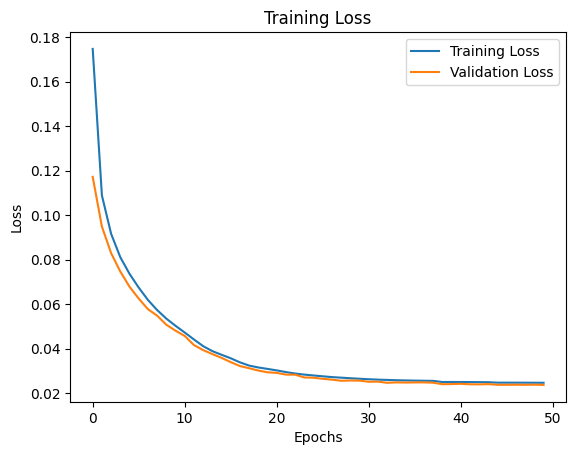

In [15]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.title("Training Loss")
plt.show()

## Evaluation

In [16]:
X_pred = model.predict(X_val)
reconstruction_errors = np.mean(np.square(X_val - X_pred), axis=(1, 2))
anomaly_scores = reconstruction_errors / np.sum(reconstruction_errors)

741/741 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


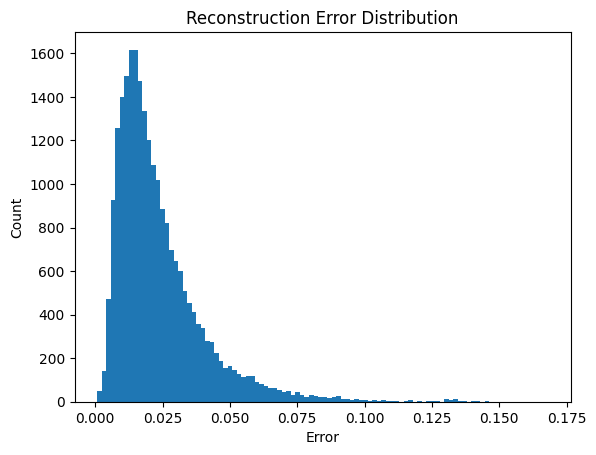

In [17]:
plt.hist(reconstruction_errors, bins=100)
plt.title("Reconstruction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()

In [18]:
# Example threshold (manual or statistical)
threshold = np.percentile(reconstruction_errors, 99)
anomalies = reconstruction_errors > threshold
print(f"Detected {anomalies.sum()} anomalies in validation set")

Detected 237 anomalies in validation set


In [19]:
def plot_anomalies(errors, threshold):
    anomalies = errors > threshold
    plt.figure(figsize=(14, 3))
    plt.plot(errors, label="Reconstruction Error")
    plt.scatter(np.where(anomalies)[0], errors[anomalies], color='red', label='Anomalies')
    plt.axhline(threshold, color="r", linestyle="--", label="Threshold")
    plt.title("Detected Anomalies")
    plt.xlabel("Sample")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

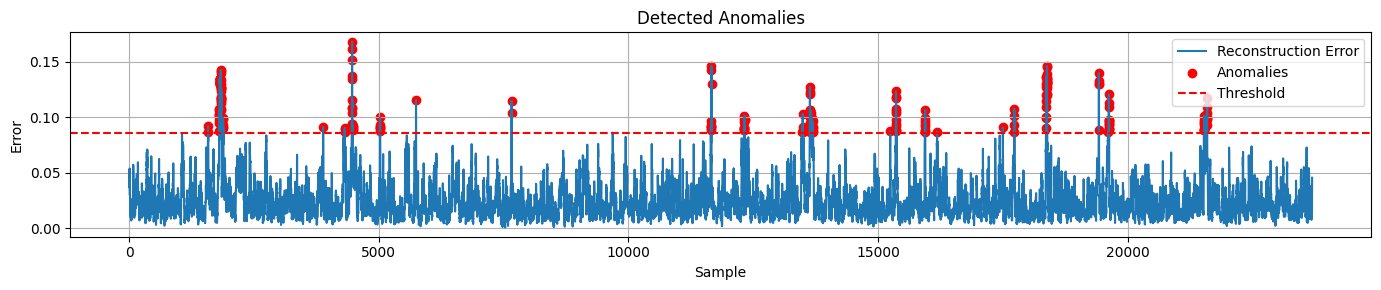

In [20]:
plot_anomalies(reconstruction_errors, threshold)

## Saving and Logging Model

In [21]:
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history.get('val_loss', [None])[-1]

log_model_results(features=FEATURES, scaler="MinMaxScaler()", window_size=WINDOW_SIZE,
                  train_loss=final_train_loss, val_loss=final_val_loss)
save_model_with_id(model)
save_training_history(history)

Model logged to logs/model_log.csv.
Model saved to models\model_20250725_1936.keras
Training history saved to models\model_20250725_1936_history.json
